In [63]:
from avaframe.in2Trans.rasterUtils import readRaster
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
import json
import numpy as np
import hashlib
import subprocess

from matplotlib.path import Path as mplPath
from matplotlib.colors import ListedColormap
from avaframe.in2Trans.shpConversion import SHP2Array
from matplotlib import colors
import pandas as pd
import pickle
import rasterio

from com1DFAUtils import *

%load_ext autoreload
%autoreload 2

# sim_case = "avaInclinedPlane"
# sim_case = "avaMal"
sim_case = "avaGar"
# sim_case = "avaHelixChannel"
# sim_case = "avaInclinedPlane"
# sim_case = "avaParabola"
friction_model = "samosat"
avaframe_dir = Path(r"C:\git\snow_avalanches\AvaFrame\avaframe")
avaframe_data_dir = avaframe_dir / ("dataDefault")

eval_app = Path(r"C:\git\webigeo\cmake-build-release-visual-studio") / "webigeo_eval.exe"

webigeo_input_dir = Path.cwd() / "webigeo_input" / "lawinensymposium"
webigeo_output_dir = Path.cwd() / "webigeo_output" / "lawinensymposium"
webigeo_sim_dir = webigeo_output_dir / sim_case
sim_case_dir = avaframe_data_dir / sim_case
avaframe_input_dir = sim_case_dir / "Inputs"
avaframe_output_dir = sim_case_dir / "Outputs" / "com1DFA"
webigeo_to_avaframe_output_dir = sim_case_dir / "Outputs" / "webigeo"
avaframe_output_peak_dir = avaframe_output_dir / "peakFiles"
release_path = avaframe_input_dir / "REL"
release_scenerios = [file.replace(".shp", "") for file in os.listdir(release_path) if file.endswith(".shp")]
print("Release scenarios:", release_scenerios)



dem_header, dem = get_dem(avaframe_input_dir)
y = np.arange(0, dem_header["nrows"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["yllcenter"]
x = np.arange(0, dem_header["ncols"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["xllcenter"]
xx, yy = np.meshgrid(x, y)

    
# np.nan_to_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Release scenarios: ['relGar', 'relGar2', 'relGar6']


In [64]:
release_areas = get_release_areas(release_path / release_scenerios[0])
print("Release areas:", release_areas)
for ra in release_areas:
    path = ra.get_path()
    vertices = path.vertices

    for v in vertices:
        v[0] -= dem_header['xllcenter']
        v[1] -= dem_header['yllcenter']
        print(v)
    # Calculate the centroid
    centroid_x = np.mean(vertices[:, 0])  # Average of x-coordinates
    centroid_y = np.mean(vertices[:, 1])  # Average of y-coordinates
    # centroid = (centroid_x - dem_header['xllcenter'], centroid_y - dem_header['yllcenter'])
    print("Centroid:", centroid_x, centroid_y)
# plot_inputs(xx, yy, dem, release_areas)

Release areas: [<matplotlib.patches.Polygon object at 0x00000257F6BCBA90>]
[ 686.1757909  1306.71969869]
[ 683.56680532 1294.58357687]
[ 684.37685175 1283.84531207]
[ 680.67467851 1267.1626827 ]
[ 677.84264626 1257.17661393]
[ 670.14675794 1247.98969859]
[ 655.40206451 1246.41652681]
[ 629.76699244 1248.01631397]
[ 615.91363155 1251.04828933]
[ 614.1911643  1259.27239335]
[ 617.71608385 1266.070649  ]
[ 637.80422068 1266.06144392]
[ 645.87576369 1269.1154638 ]
[ 643.97294633 1275.30696199]
[ 635.91979104 1283.31628708]
[ 624.97019146 1284.96186254]
[ 616.04148574 1286.12158148]
[ 604.37160252 1290.24239052]
[ 591.4789693  1283.80510769]
[ 574.79692256 1295.46087848]
[ 557.67471205 1285.10771143]
[ 542.43172291 1270.60320337]
[ 526.18746933 1272.45280287]
[ 511.54332135 1276.12722948]
[ 501.16935454 1276.83287433]
[ 486.96373507 1281.30631107]
[ 470.79867436 1295.79720023]
[ 452.58164035 1309.95948185]
[ 435.81583259 1327.37996808]
[ 425.43068453 1335.73382925]
[ 396.28180492 1325.53814

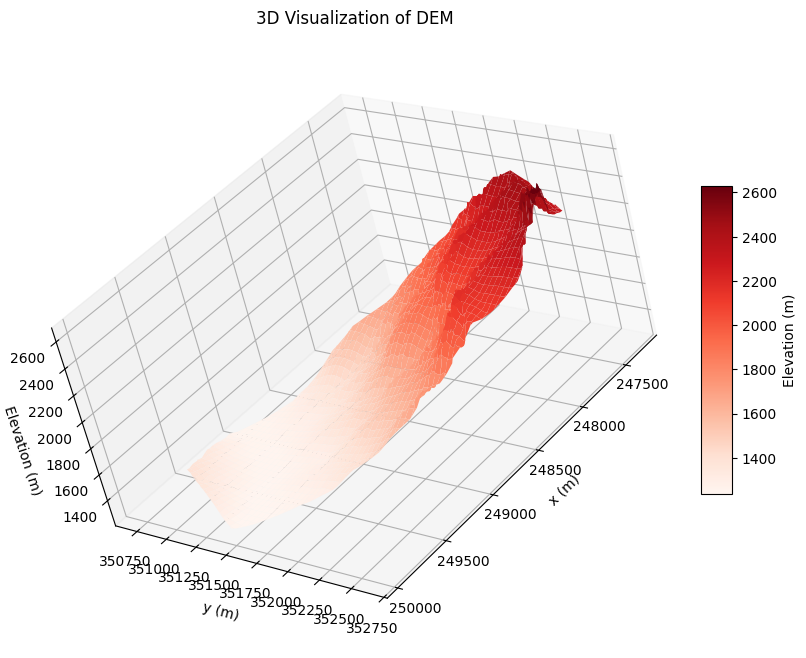

In [65]:
fig, ax = plot_dem_3d(xx, yy, dem)
ax.view_init(elev=30, azim=45, roll=15)

In [66]:
files = [file for file in os.listdir(avaframe_output_peak_dir) if file.endswith("pfv.asc") if file.find("null") != -1 if file.find("webigeo") == -1]
print(avaframe_output_dir)
print(files)
flow_velocity_file = avaframe_output_peak_dir / files[0]
dfa_flow_velocity = np.zeros_like(dem)
flow_velocity = readRaster(flow_velocity_file, noDataToNan=True)
flow_velocity_header = flow_velocity["header"]
flow_velocity = flow_velocity["rasterData"]
dfa_flow_velocity[:flow_velocity.shape[0], :flow_velocity.shape[1]] = flow_velocity

C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaGar\Outputs\com1DFA
['relGar2_a862d4a766_D_L_null_dfa_pfv.asc', 'relGar6_4a9636e4d8_D_L_null_dfa_pfv.asc', 'relGar_3bd88bce2c_D_L_null_dfa_pfv.asc']


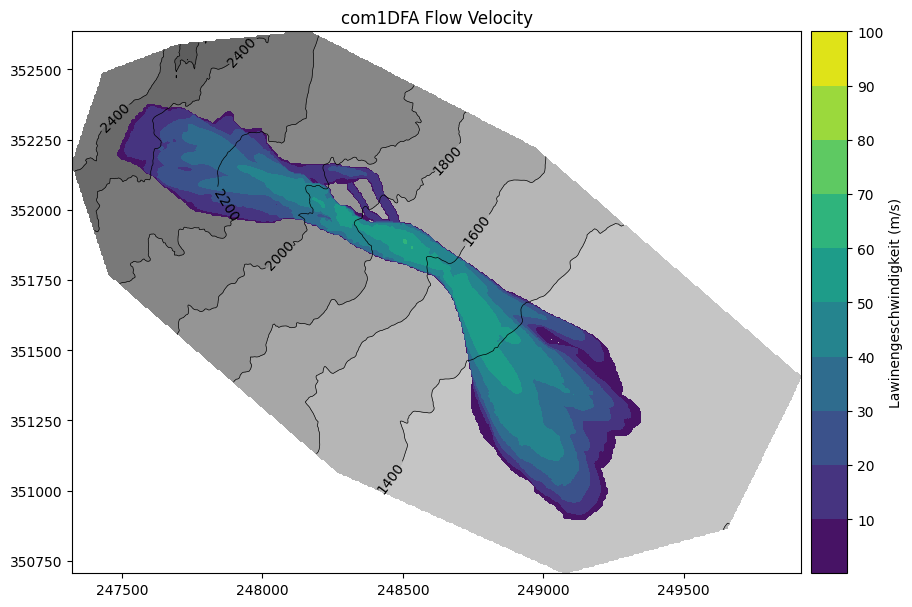

In [67]:

plot_flow_velocity(dfa_flow_velocity, dem, xx, yy, title="com1DFA Flow Velocity");

In [68]:
# prepare webigeo simulation
for release_scenerio in release_scenerios:
    pattern = webigeo_input_dir / sim_case / release_scenerio / "*.json"

    # Use glob to find all matching files
    for file in Path(pattern.parent).glob(pattern.name):
        print(f"Removing file: {file}")
        os.remove(file)
    release_areas = get_release_areas(release_path / (release_scenerio + ".shp"))
    input_path =  webigeo_input_dir / sim_case / release_scenerio
    webigeo_export_release_points_path = input_path / "release_points"
    webigeo_export_dem_path = input_path / "heights"
    os.makedirs(input_path, exist_ok=True)
    os.makedirs(webigeo_export_release_points_path, exist_ok=True)
    os.makedirs(webigeo_export_dem_path, exist_ok=True)
    export_webigeo_release_points(webigeo_export_release_points_path, xx, yy, release_areas)
    corrected_dem = dem_np_to_webigeo(webigeo_export_dem_path, dem_header, dem)
    friction_model = "samosat"
    settings = export_webigeo_settings(input_path, webigeo_output_dir / sim_case / release_scenerio, 
                                    random_contribution=16, 
                                    persistence=0.4, 
                                    alpha=27,
                                    num_paths_per_release_cell=8, 
                                    num_steps=5000,
                                    model=0, 
                                    friction_model=friction_model.lower(),
                                    # friction_coeff=0.4,
                                    slab_thickness=1)
    print("Exported webigeo settings to", input_path)

Removing file: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar\settings_d06f89_pers_0.40_rand_16.00_n_8_s_5000_a_27.json
DEM: (387, 520) 201240
Release pixels: 1634
Exported webigeo settings to c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar
Removing file: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar2\settings_e09d50_pers_0.40_rand_16.00_n_8_s_5000_a_27.json
DEM: (387, 520) 201240
Release pixels: 6918
Exported webigeo settings to c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar2
Removing file: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6\settings_07e44b_pers_0.40_rand_16.00_n_8_s_5000_a_27.json
DEM: (387, 520) 201240
Release pixels: 3219
Exported webigeo settings to c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6


C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaGar\Outputs\com1DFA
['relGar_3bd88bce2c_D_L_null_dfa_pfv.asc']
Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar\settings_d06f89_pers_0.40_rand_16.00_n_8_s_5000_a_27.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar
Plot: c:\git\evaluation-utilities\webigeo_output\lawinensymposium\avaGar\relGar\d06f89_pers_0.40_rand_16.00_n_8_s_5000_a_27\trajectories\texture_layer1_zdelta.png


c:\git\evaluation-utilities\com1DFAUtils.py:274: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))
C:\Users\magge\AppData\Local\Temp\ipykernel_408\2440295978.py:47: UserWarning: The following kwargs were not used by contour: 'label', 'dark'
  ax.contour(xx, yy, dfa_flow_velocity > 0, colors="orangered", alpha=1, label="com1DFA Umriss", dark=False)


C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaGar\Outputs\com1DFA
['relGar2_a862d4a766_D_L_null_dfa_pfv.asc']
Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar2
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar2\settings_e09d50_pers_0.40_rand_16.00_n_8_s_5000_a_27.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar2
Plot: c:\git\evaluation-utilities\webigeo_output\lawinensymposium\avaGar\relGar2\e09d50_pers_0.40_rand_16.00_n_8_s_5000_a_27\trajectories\texture_layer1_zdelta.png


c:\git\evaluation-utilities\com1DFAUtils.py:274: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))
C:\Users\magge\AppData\Local\Temp\ipykernel_408\2440295978.py:47: UserWarning: The following kwargs were not used by contour: 'label', 'dark'
  ax.contour(xx, yy, dfa_flow_velocity > 0, colors="orangered", alpha=1, label="com1DFA Umriss", dark=False)


C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaGar\Outputs\com1DFA
['relGar6_4a9636e4d8_D_L_null_dfa_pfv.asc']
Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6\settings_07e44b_pers_0.40_rand_16.00_n_8_s_5000_a_27.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6
Plot: c:\git\evaluation-utilities\webigeo_output\lawinensymposium\avaGar\relGar6\07e44b_pers_0.40_rand_16.00_n_8_s_5000_a_27\trajectories\texture_layer1_zdelta.png


c:\git\evaluation-utilities\com1DFAUtils.py:274: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))
C:\Users\magge\AppData\Local\Temp\ipykernel_408\2440295978.py:47: UserWarning: The following kwargs were not used by contour: 'label', 'dark'
  ax.contour(xx, yy, dfa_flow_velocity > 0, colors="orangered", alpha=1, label="com1DFA Umriss", dark=False)


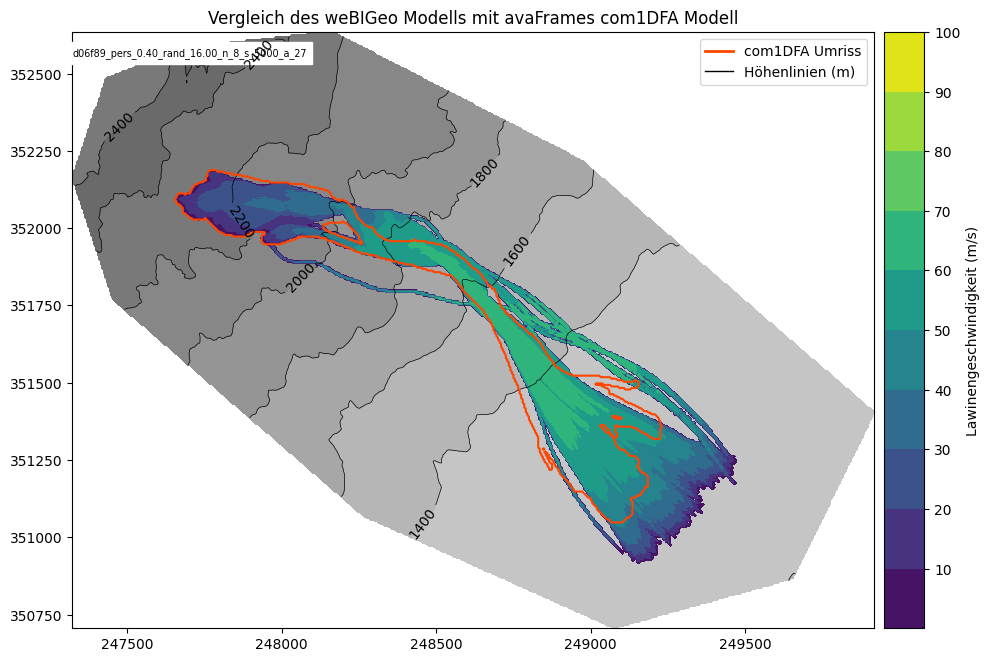

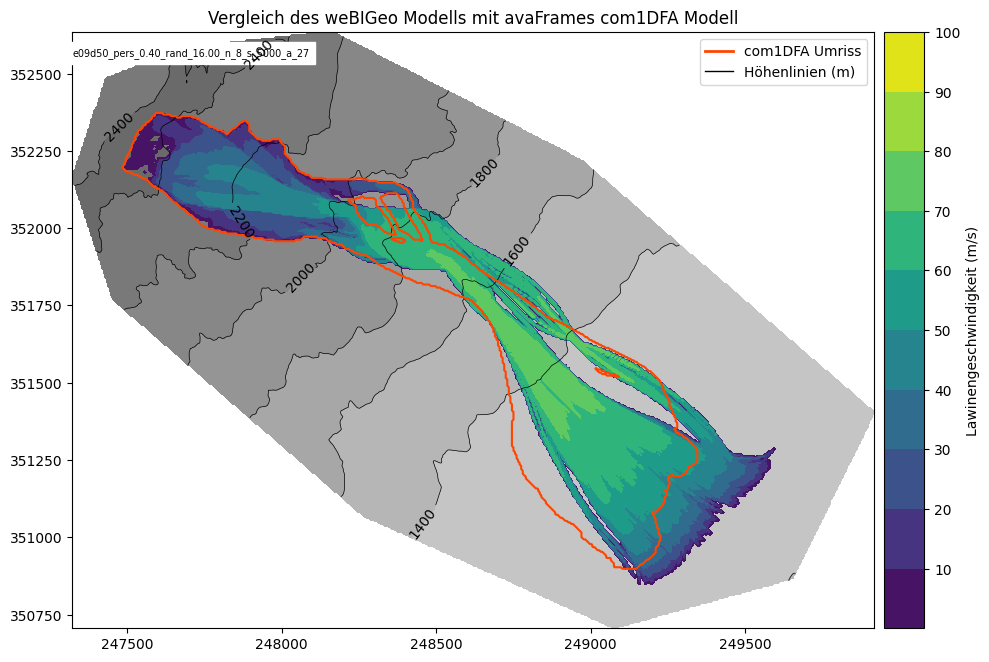

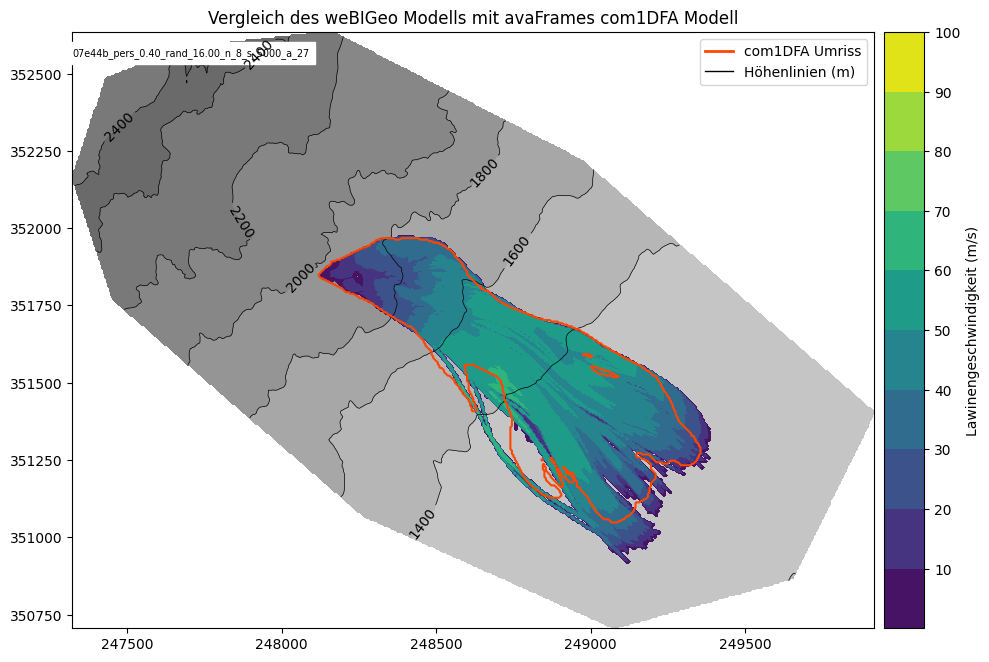

In [71]:
# run all simulations
sim_cases = ["avaParabola", "avaHelixChannel", "avaMal", "avaInclinedPlane", "avaPyramid", "avaKot", "avaGar"]
# eval_app = Path(r"C:\git\webigeo\cmake-build-debug-visual-studio") / "webigeo_eval.exe"
eval_app = Path(r"C:\git\webigeo\cmake-build-release-visual-studio") / "webigeo_eval.exe"
import subprocess
for release_scenerio in os.listdir(webigeo_input_dir / sim_case):
    sim_dir = webigeo_input_dir / sim_case / release_scenerio
    
    _df = pd.read_csv(avaframe_output_dir / "configurationFiles" / "allConfigurations.csv")
    dfa_hash = _df[(_df.simTypeList.isna()) & (_df.releaseScenario == release_scenerio)].simName.values[0].split("_")[1]
    files = [file for file in os.listdir(avaframe_output_peak_dir) if file.endswith("pfv.asc") if file.find("null") != -1 if file.find("webigeo") == -1 if file.find(dfa_hash) != -1]
    print(avaframe_output_dir)
    print(files)
    
    flow_velocity_file = avaframe_output_peak_dir / files[0]
    dfa_flow_velocity = np.zeros_like(dem)
    flow_velocity = readRaster(flow_velocity_file, noDataToNan=True)
    flow_velocity_header = flow_velocity["header"]
    flow_velocity = flow_velocity["rasterData"]
    dfa_flow_velocity[:flow_velocity.shape[0], :flow_velocity.shape[1]] = flow_velocity
    for file in os.listdir(sim_dir):
        if file.startswith("settings") and file.endswith(".json"):
            settings_file = webigeo_input_dir / sim_case / release_scenerio / file
            print("Running Webigeo in: ", webigeo_input_dir / sim_case / release_scenerio)
            print("Running Webigeo with settings file: ", settings_file)
            print("Running Webigeo app: ", eval_app)
            result = subprocess.run([eval_app, settings_file], capture_output=True, text=True)

            # Print the output
            if "Error while parsing WGSL" in result.stdout:
                print("STDOUT:")
                print(result.stdout)
            print("Return Code:", result.returncode)

            plot_dir = sim_dir / "plots"
            os.makedirs(plot_dir, exist_ok=True)

            settings = json.load(open(sim_dir / file))
            print(f"Save to: {sim_dir}")
            identifier = file.replace(".json", "").replace("settings_", "")
            png_filename = webigeo_output_dir / sim_case / release_scenerio / identifier / r"trajectories\texture_layer1_zdelta.png"
            print(f"Plot: {png_filename}")
            velocity = read_webigeo_flow_velocity_from_z_delta(png_filename)
            # velocity[velocity > 100] = np.nan
            
            fig, ax = plot_flow_velocity(velocity, corrected_dem, xx, yy, title=f"Vergleich des weBIGeo Modells mit avaFrames com1DFA Modell")
            ax.contour(xx, yy, dfa_flow_velocity > 0, colors="orangered", alpha=1, label="com1DFA Umriss", dark=False)
            ax.text(0, .96, identifier, size="x-small", backgroundcolor="white", color="black", transform=ax.transAxes)
            # ax.axhline(-4000, color="red", linestyle="--", alpha=0.5)
            
            from matplotlib.lines import Line2D
            ax.legend(handles=[
                Line2D([0], [0], color="orangered", linewidth=2, label="com1DFA Umriss"),
                Line2D([0], [0], color="black", linewidth=1, label="Höhenlinien (m)")
                ])
            fig.tight_layout()
            fig.savefig(plot_dir / f"{identifier}_flow_velocity.png", dpi=300)

            # fig, ax = plot_flow_velocity_diff(velocity, np.where((velocity > 1) & (dfa_flow_velocity > 1), dfa_flow_velocity, np.nan), corrected_dem, xx, yy)
            # fig.savefig(plot_dir / f"{sim_case}_flow_velocity_diff.png", dpi=300)

            if sim_case in ["avaInclinedPlane", "avaParabola"]:
                offset = 5
                y_plane = int(dem.shape[0]/2)
                fig, ax = plt.subplots()
                ax.plot(xx[0,offset:-offset], velocity[y_plane,offset:-offset])
                ax.plot(xx[0,offset:-offset], dfa_flow_velocity[y_plane,offset:-offset])
                ax.set(xlabel="X [m]", ylabel="Flow Velocity [m/s]", title=f"Comparison of Flow Velocity for {friction_model.title()} Friction Model")
                ax.legend(["Webigeo", "com1DFA"])
                fig.savefig(plot_dir / f"{identifier}_flow_comparison.png", dpi=300)

No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaParabola\Inputs\REL\release1PF.shp


Release scenarios: ['release1PF']
Removing file: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaParabola\release1PF\settings_595b55_pers_0.40_rand_16.00_n_3_s_4000_a_25.json
DEM: (401, 1001) 401401
Release pixels: 3500
Exported webigeo settings to c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaParabola\release1PF


No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaParabola\Inputs\REL\release1PF.shp


C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaParabola\Outputs\com1DFA
['release1PF_58d9209cd9_D_L_null_dfa_pfv.asc']
Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaParabola\release1PF
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaParabola\release1PF\settings_595b55_pers_0.40_rand_16.00_n_3_s_4000_a_25.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\plots
Plot: c:\git\evaluation-utilities\webigeo_output\lawinensymposium\avaParabola\release1PF\595b55_pers_0.40_rand_16.00_n_3_s_4000_a_25\trajectories\texture_layer1_zdelta.png
Release scenarios: ['release1HX']
Removing file: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaHelixChannel\release1HX\settings_becafc_pers_0.40_rand_16.00_n_3_s_4000_a_25.json
DEM: (401, 1001) 401401
Release pixels: 5073
Expor

No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaInclinedPlane\Inputs\REL\release1IP.shp
No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaInclinedPlane\Inputs\REL\release1IP.shp


Release scenarios: ['release1IP']
Removing file: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaInclinedPlane\release1IP\settings_c70831_pers_0.40_rand_16.00_n_3_s_4000_a_25.json
DEM: (401, 1001) 401401
Release pixels: 3245
Exported webigeo settings to c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaInclinedPlane\release1IP
C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaInclinedPlane\Outputs\com1DFA
['release1IP_9574940bb2_D_L_null_dfa_pfv.asc']
Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaInclinedPlane\release1IP
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaInclinedPlane\release1IP\settings_c70831_pers_0.40_rand_16.00_n_3_s_4000_a_25.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\plots
Plot: c:\git\evaluation-utilities\webigeo_out

C:\Users\magge\AppData\Local\Temp\ipykernel_408\1742797394.py:137: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, flowpy_velocity > 0, colors="purple", alpha=1, label="com4FlowPy Umriss")


C:\git\snow_avalanches\AvaFrame\avaframe\dataDefault\avaGar\Outputs\com1DFA
['relGar6_4a9636e4d8_D_L_null_dfa_pfv.asc']
Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\lawinensymposium\avaGar\relGar6\settings_cc6db3_pers_0.40_rand_16.00_n_3_s_4000_a_25.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\lawinensymposium\plots
Plot: c:\git\evaluation-utilities\webigeo_output\lawinensymposium\avaGar\relGar6\cc6db3_pers_0.40_rand_16.00_n_3_s_4000_a_25\trajectories\texture_layer1_zdelta.png


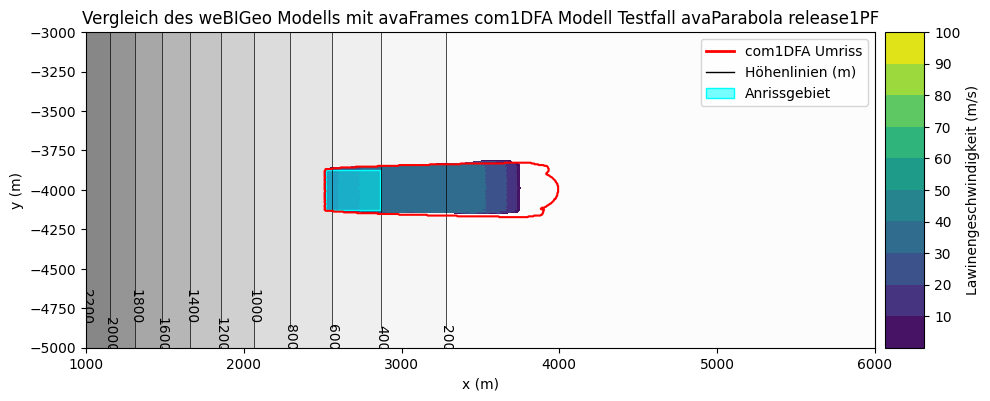

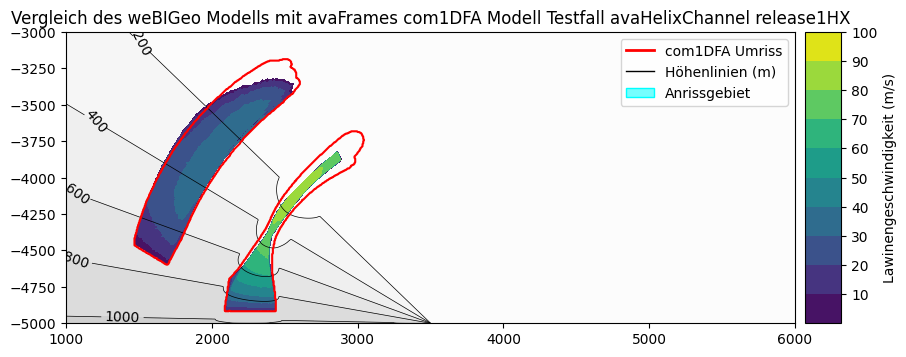

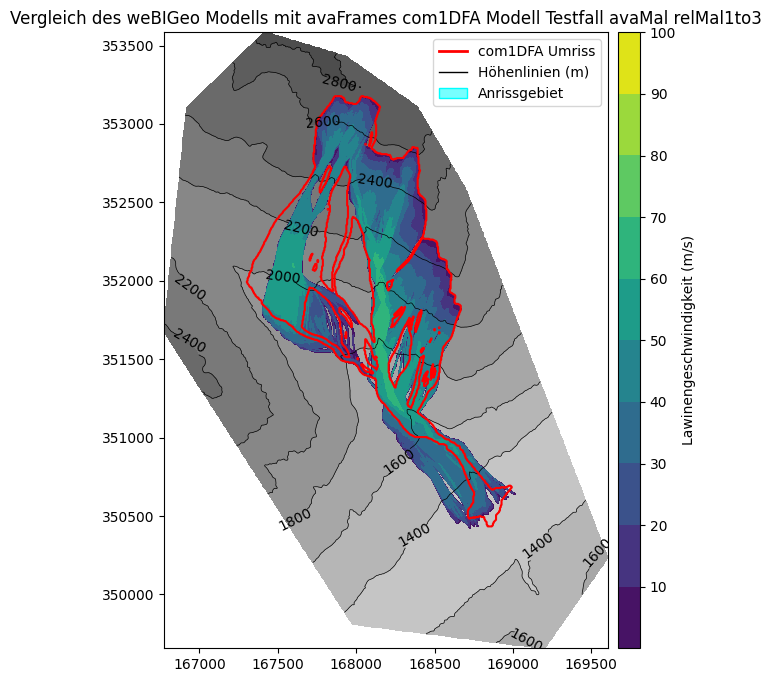

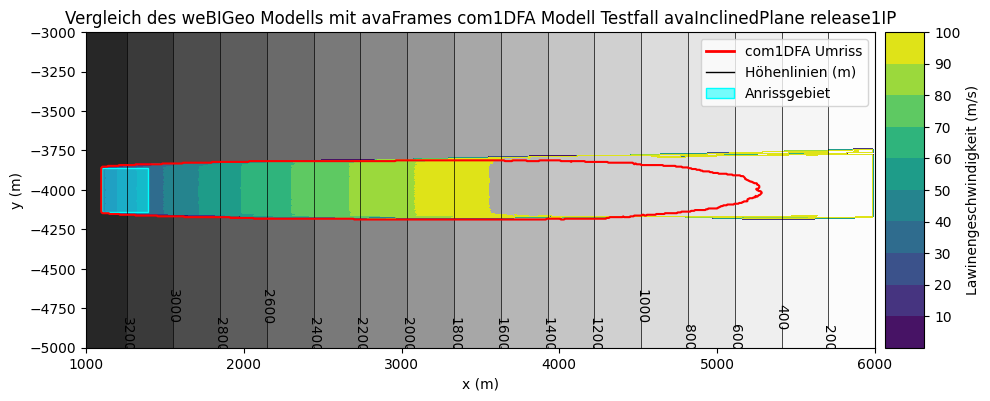

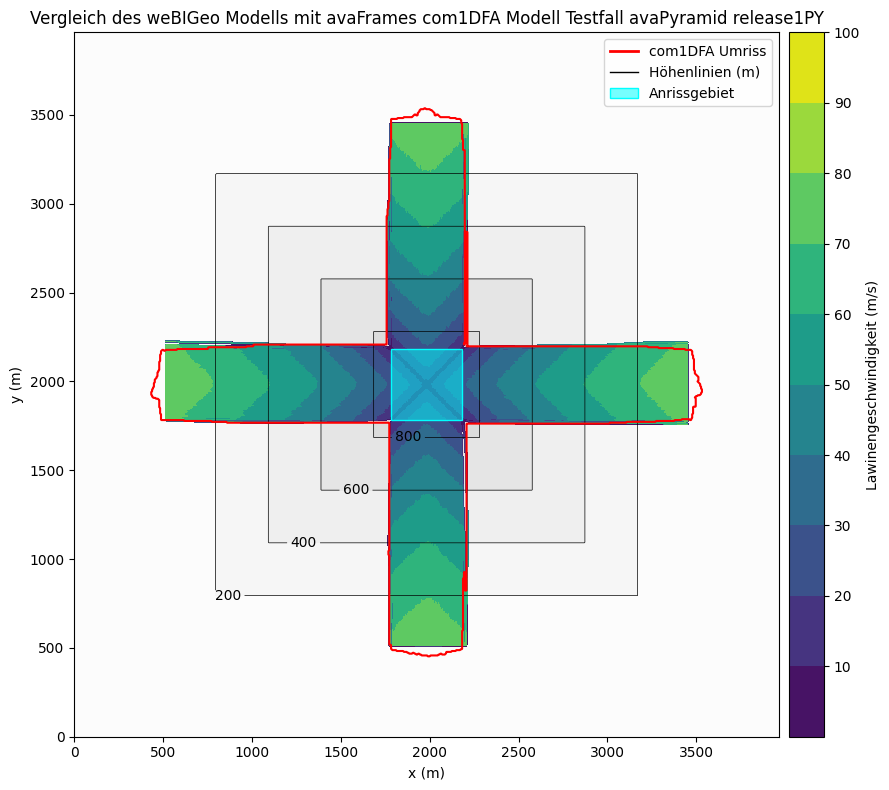

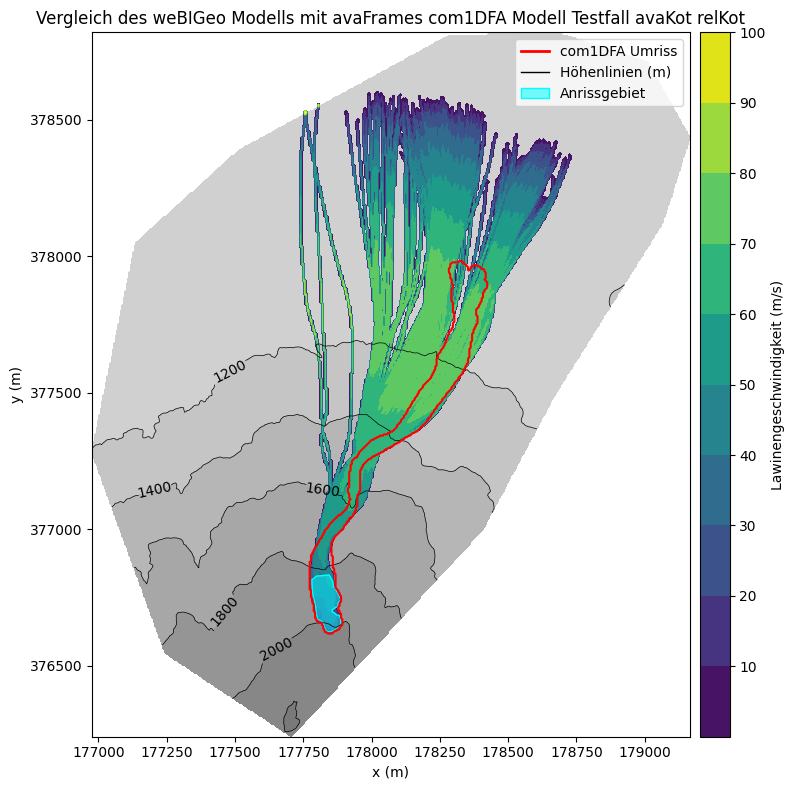

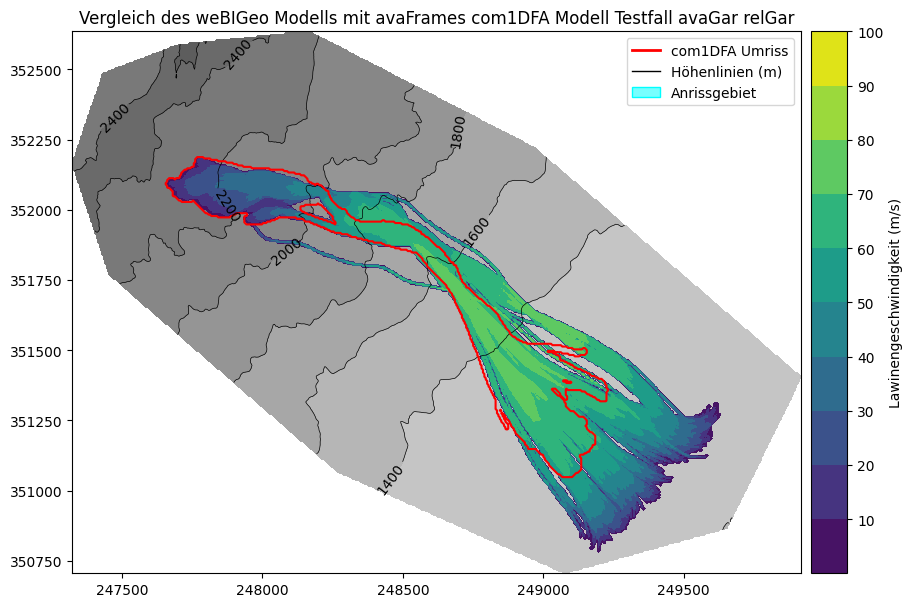

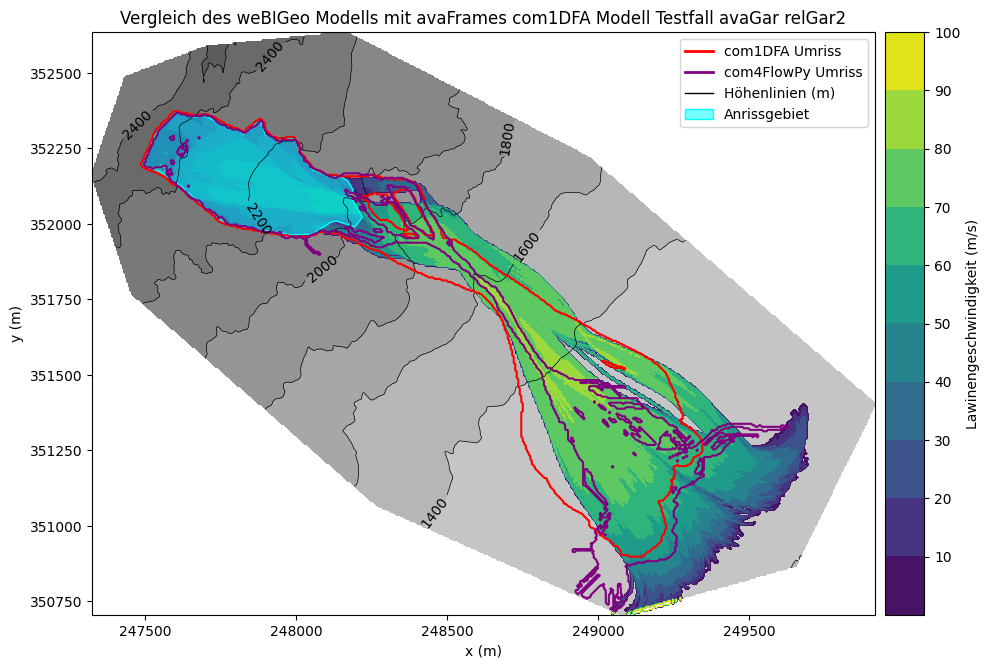

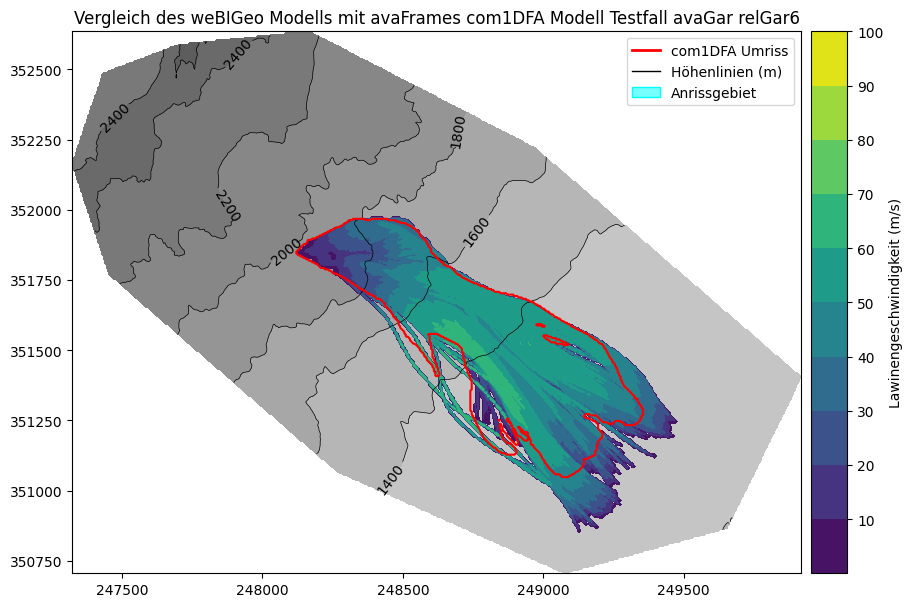

In [15]:
# run all simulations
sim_cases = ["avaParabola", "avaHelixChannel", 
    "avaMal", "avaInclinedPlane", "avaPyramid", "avaKot", "avaGar"]
for sim_case in sim_cases:
    avaframe_data_dir = avaframe_dir / ("dataDefault")

    eval_app = Path(r"C:\git\webigeo\cmake-build-release-visual-studio") / "webigeo_eval.exe"

    webigeo_input_dir = Path.cwd() / "webigeo_input" / "lawinensymposium"
    webigeo_output_dir = Path.cwd() / "webigeo_output" / "lawinensymposium"
    # set paths
    webigeo_sim_dir = webigeo_output_dir / sim_case
    sim_case_dir = avaframe_data_dir / sim_case
    avaframe_input_dir = sim_case_dir / "Inputs"
    avaframe_output_dir = sim_case_dir / "Outputs" / "com1DFA"
    webigeo_to_avaframe_output_dir = sim_case_dir / "Outputs" / "webigeo"
    avaframe_output_peak_dir = avaframe_output_dir / "peakFiles"
    release_path = avaframe_input_dir / "REL"
    release_scenerios = [file.replace(".shp", "") for file in os.listdir(release_path) if file.endswith(".shp")]
    print("Release scenarios:", release_scenerios)


    # get dem
    dem_header, dem = get_dem(avaframe_input_dir)
    # avoid negative values, webigeo sets them to 0 otherwise
    min_height = dem.min()
    if min_height < 1:
        dem = dem - min_height + 1

    y = np.arange(0, dem_header["nrows"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["yllcenter"]
    x = np.arange(0, dem_header["ncols"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["xllcenter"]
    xx, yy = np.meshgrid(x, y)


    for release_scenerio in release_scenerios:

        # prepare webigeo simulation
        pattern = webigeo_input_dir / sim_case / release_scenerio / "*.json"

        # Use glob to find all matching files
        for file in Path(pattern.parent).glob(pattern.name):
            print(f"Removing file: {file}")
            os.remove(file)
        release_areas = get_release_areas(release_path / (release_scenerio + ".shp"))
        input_path =  webigeo_input_dir / sim_case / release_scenerio
        webigeo_export_release_points_path = input_path / "release_points"
        webigeo_export_dem_path = input_path / "heights"
        os.makedirs(input_path, exist_ok=True)
        os.makedirs(webigeo_export_release_points_path, exist_ok=True)
        os.makedirs(webigeo_export_dem_path, exist_ok=True)
        export_webigeo_release_points(webigeo_export_release_points_path, xx, yy, release_areas)
        corrected_dem = dem_np_to_webigeo(webigeo_export_dem_path, dem_header, dem)
        friction_model = "samosat"
        settings = export_webigeo_settings(input_path, webigeo_output_dir / sim_case / release_scenerio, 
                                        random_contribution=16, 
                                        persistence=0.4, 
                                        alpha=25,
                                        num_paths_per_release_cell=3, 
                                        num_steps=4000,
                                        model=0, 
                                        friction_model=friction_model.lower(),
                                        # friction_coeff=0.4,
                                        slab_thickness=1)
        print("Exported webigeo settings to", input_path)

    # eval_app = Path(r"C:\git\webigeo\cmake-build-debug-visual-studio") / "webigeo_eval.exe"
    eval_app = Path(r"C:\git\webigeo\cmake-build-release-visual-studio") / "webigeo_eval.exe"
    import subprocess
    for release_scenerio in os.listdir(webigeo_input_dir / sim_case):
        sim_dir = webigeo_input_dir / sim_case / release_scenerio
        
        release_areas = get_release_areas(release_path / (release_scenerio + ".shp"))
        
        # load com1DFA data
        files = [file for file in os.listdir(avaframe_output_peak_dir) if file.endswith("pfv.asc") if file.find("null") != -1 if file.find("webigeo") == -1 if file.startswith(release_scenerio + "_")]
        print(avaframe_output_dir)
        print(files)
        flow_velocity_file = avaframe_output_peak_dir / files[0]
        dfa_flow_velocity = np.zeros_like(dem)
        flow_velocity = readRaster(flow_velocity_file, noDataToNan=True)
        flow_velocity_header = flow_velocity["header"]
        flow_velocity = flow_velocity["rasterData"]
        # dem and flow velocity array shapes can differ
        dfa_flow_velocity[:flow_velocity.shape[0], :flow_velocity.shape[1]] = flow_velocity
        
        # with rasterio.open(tiff_file) as src:
        #     # Read the height data from the first band
        #     data = np.sqrt(2*9.81*np.flipud(src.read(1)))
        for file in os.listdir(sim_dir):
            if file.startswith("settings") and file.endswith(".json"):
                settings_file = webigeo_input_dir / sim_case / release_scenerio / file
                print("Running Webigeo in: ", webigeo_input_dir / sim_case / release_scenerio)
                print("Running Webigeo with settings file: ", settings_file)
                print("Running Webigeo app: ", eval_app)
                result = subprocess.run([eval_app, settings_file], capture_output=True, text=True)

                # Print the output
                if "Error while parsing WGSL" in result.stdout:
                    print("STDOUT:")
                    print(result.stdout)
                print("Return Code:", result.returncode)

                plot_dir = webigeo_input_dir / "plots"
                os.makedirs(plot_dir, exist_ok=True)

                settings = json.load(open(sim_dir / file))
                print(f"Save to: {plot_dir}")
                identifier = file.replace(".json", "").replace("settings_", "")
                png_filename = webigeo_output_dir / sim_case / release_scenerio / identifier / r"trajectories\texture_layer1_zdelta.png"
                print(f"Plot: {png_filename}")
                velocity = read_webigeo_flow_velocity_from_z_delta(png_filename)
                # velocity[velocity > 100] = np.nan
                
                fig, ax = plot_flow_velocity(velocity, dem, xx, yy, title=f"Vergleich des weBIGeo Modells mit avaFrames com1DFA Modell Testfall {sim_case} {release_scenerio}", dark=False)
                ax.contour(xx, yy, dfa_flow_velocity > 0, colors="red", alpha=1)
                
                from matplotlib.lines import Line2D
                from matplotlib.patches import Patch
                ax.legend(handles=[
                    Line2D([0], [0], color="red", linewidth=2, label="com1DFA Umriss"),
                    Line2D([0], [0], color="black", linewidth=1, label="Höhenlinien (m)"),
                    Patch(facecolor='#00ffff88', edgecolor='#00ffffff', label="Anrissgebiet")
                    ])
                if sim_case in ["avaHelixChannel", "avaMal", "avaGar"]:
                    if sim_case == "avaMal":
                        tiff_file = r"C:\Users\magge\Downloads\flowpy-outputs\avaMal\Outputs\com4FlowPy\peakFiles\res_ee06b2abc4\com4_ee06b2abc4_20250520_175633_zdelta.tif"
                    if sim_case == "avaHelixChannel":
                        tiff_file = r"C:\Users\magge\Downloads\flowpy-outputs\avaHelixChannel\Outputs\com4FlowPy\peakFiles\res_195d01b4aa\com4_195d01b4aa_20250520_164732_zdelta.tif"
                    if sim_case == "avaGar" and release_scenerio == "relGar2":
                        tiff_file = r"C:\Users\magge\Downloads\avaGar\avaGar\Outputs\com4FlowPy\peakFiles\res_e1444e6d13\com4_e1444e6d13_20250527_122448_zdelta.tif"
                    else:
                        break
                    
                    with rasterio.open(tiff_file) as src:
                        # Read the height data from the first band
                        flowpy_velocity = np.sqrt(2*9.81*np.flipud(src.read(1)))
                    ax.contour(xx, yy, flowpy_velocity > 0, colors="purple", alpha=1, label="com4FlowPy Umriss")
                    ax.legend(handles=[
                        Line2D([0], [0], color="red", linewidth=2, label="com1DFA Umriss"),
                        Line2D([0], [0], color="purple", linewidth=2, label="com4FlowPy Umriss"),
                        Line2D([0], [0], color="black", linewidth=1, label="Höhenlinien (m)"),
                        Patch(facecolor='#00ffff88', edgecolor='#00ffffff', label="Anrissgebiet")
                    ])
                # ax.text(0, .96, identifier, size="x-small", backgroundcolor="white", color="black", transform=ax.transAxes)
                # ax.axhline(-4000, color="red", linestyle="--", alpha=0.5)
                
                
                ax.set_xlabel('x (m)')
                ax.set_ylabel('y (m)')

                for polygon in release_areas:
                    new_polygon = Polygon(polygon.get_xy(), closed=True, edgecolor='#00ffffff', facecolor='#00ffff88')
                    ax.add_patch(new_polygon)
                fig.tight_layout()
                fig.savefig(plot_dir / f"{identifier}_flow_velocity.png", dpi=300)

                # fig, ax = plot_flow_velocity_diff(velocity, np.where((velocity > 1) & (dfa_flow_velocity > 1), dfa_flow_velocity, np.nan), corrected_dem, xx, yy)
                # fig.savefig(plot_dir / f"{sim_case}_flow_velocity_diff.png", dpi=300)

                # if sim_case in ["avaInclinedPlane", "avaParabola"]:
                #     offset = 5
                #     y_plane = int(dem.shape[0]/2)
                #     fig, ax = plt.subplots()
                #     ax.plot(xx[0,offset:-offset], velocity[y_plane,offset:-offset])
                #     ax.plot(xx[0,offset:-offset], dfa_flow_velocity[y_plane,offset:-offset])
                #     ax.set(xlabel="X [m]", ylabel="Flow Velocity [m/s]", title=f"Comparison of Flow Velocity for {friction_model.title()} Friction Model")
                #     ax.legend(["Webigeo", "com1DFA"])
                #     fig.savefig(plot_dir / f"{identifier}_flow_comparison.png", dpi=300)

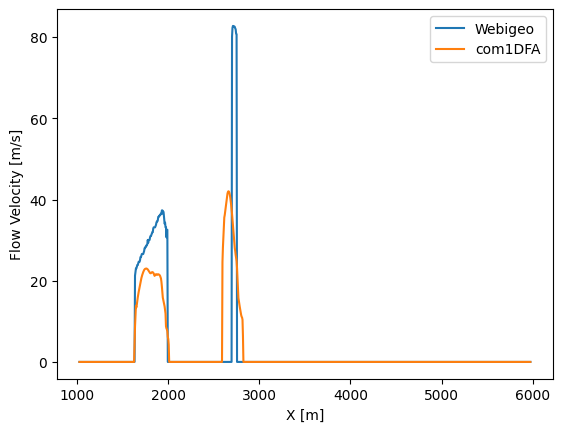

In [77]:
offset = 5
y_plane = int(dem.shape[0]/2)
plt.plot(xx[0,offset:-offset], velocity[y_plane,offset:-offset])
plt.plot(xx[0,offset:-offset], dfa_flow_velocity[y_plane,offset:-offset])
plt.xlabel("X [m]")
plt.ylabel("Flow Velocity [m/s]")
plt.legend(["Webigeo", "com1DFA"])


c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\090823_pers_0.90_rand_0.50_n_256_s_2000_a_25
c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\9096a0_pers_0.90_rand_0.50_n_256_s_3000_a_25
c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\cf461c_pers_0.90_rand_0.50_n_256_s_4000_a_25
c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\d6979d_pers_0.90_rand_0.50_n_256_s_5000_a_25


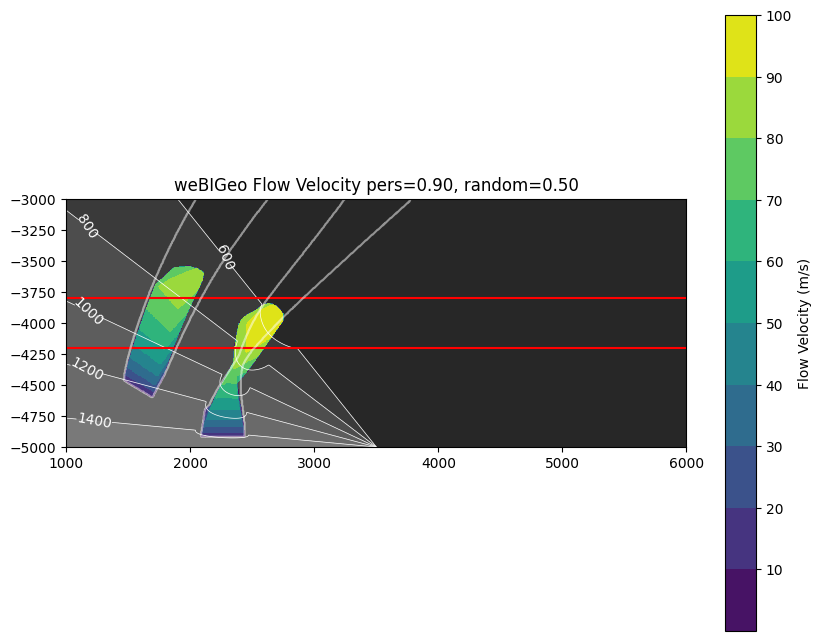

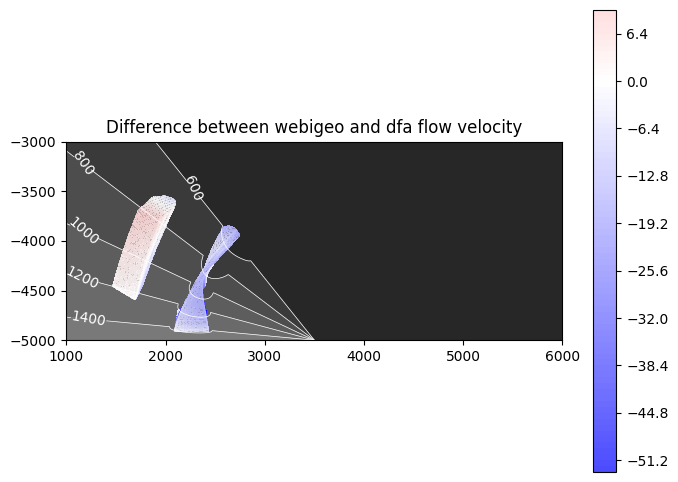

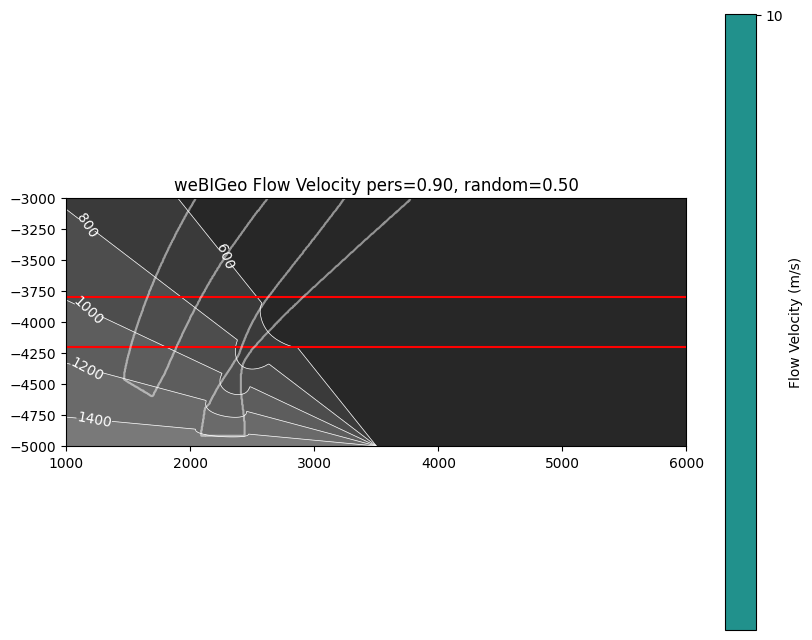

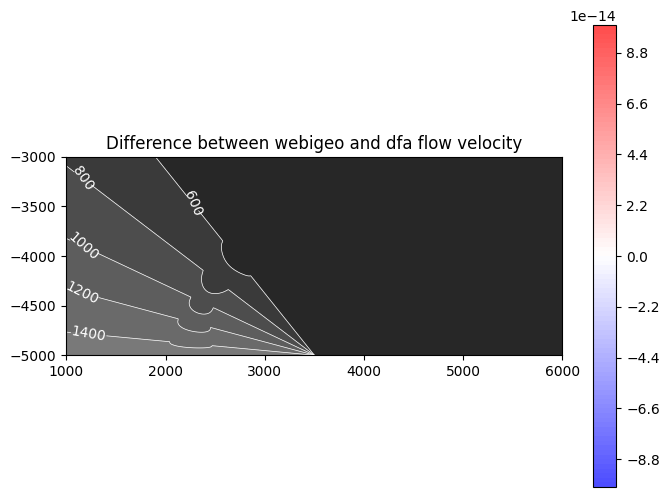

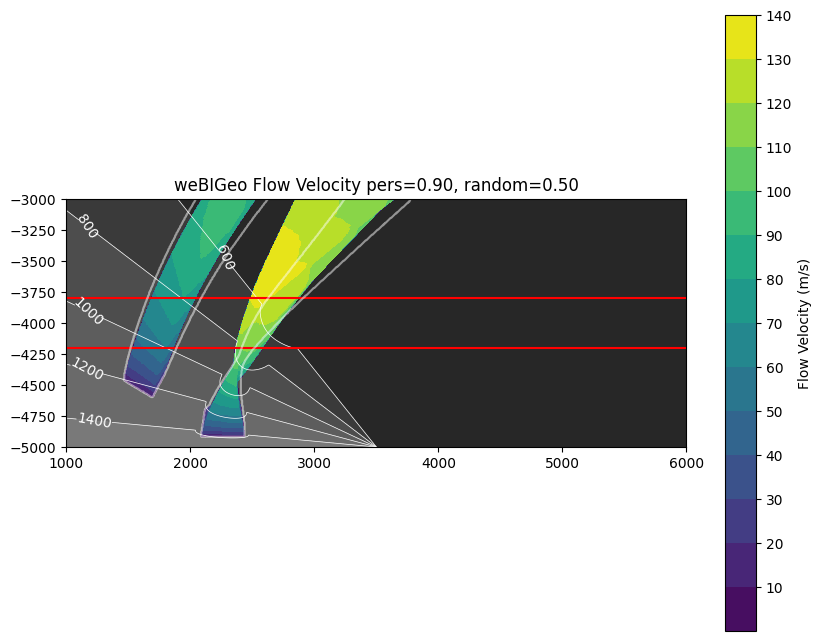

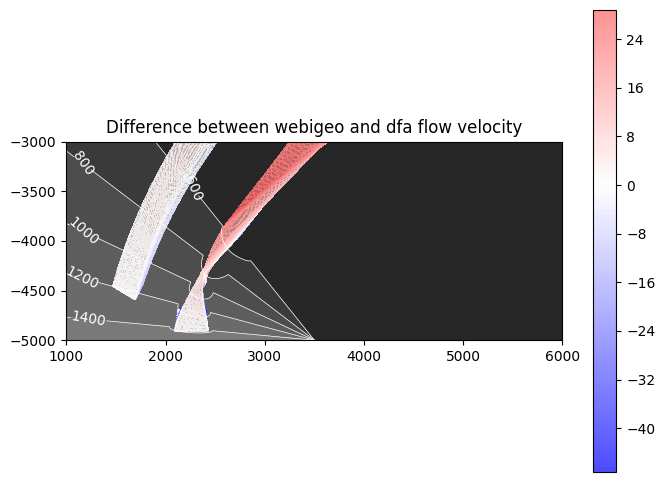

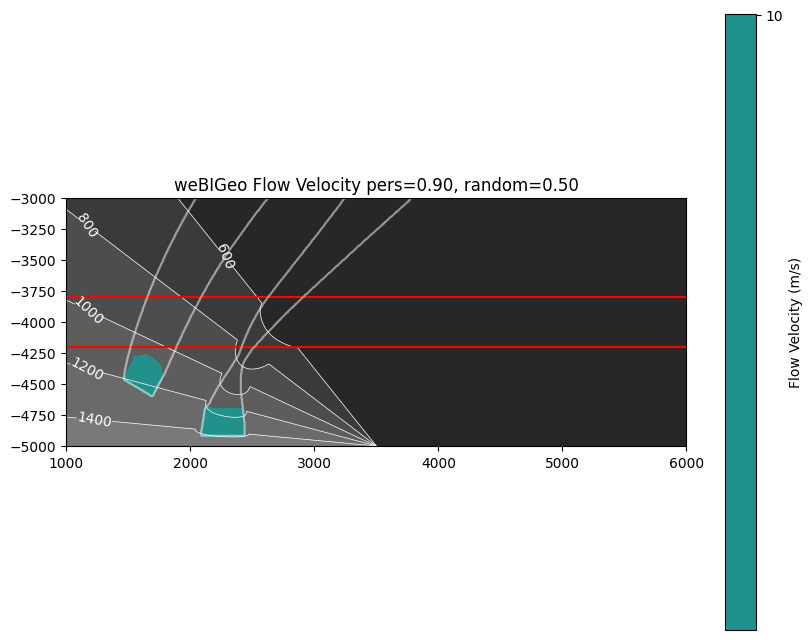

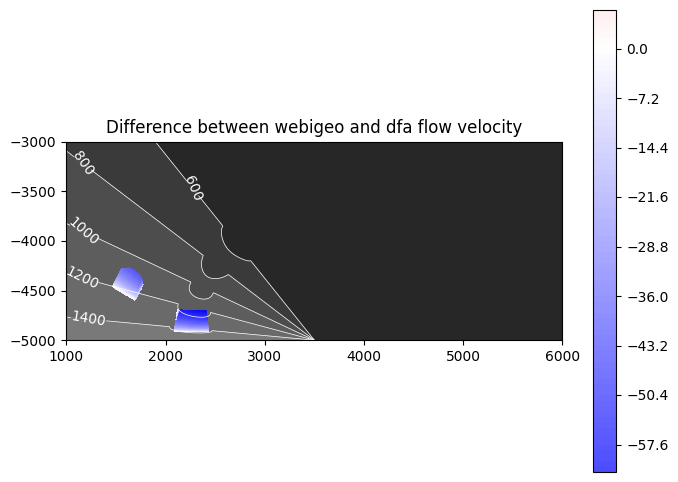

In [ ]:
for release_scenerio in release_scenerios:
    d = webigeo_output_dir / sim_case / release_scenerio
    sim_cases = [dd for dd in os.listdir(d) if os.path.isdir(d / dd) and dd != "plots"]
    shifted_dem_mask = np.ones_like(corrected_dem, dtype=bool)
    shifted_dem_mask_left = np.ones_like(corrected_dem, dtype=bool)
    shifted_dem_mask_right = np.ones_like(corrected_dem, dtype=bool)
    edge_distance = 3
    shifted_dem_mask_left[:, :-edge_distance] = np.isnan(corrected_dem)[:, edge_distance:]
    shifted_dem_mask_right[:, edge_distance:] = np.isnan(corrected_dem)[:, :-edge_distance]
    shifted_dem_mask = shifted_dem_mask_left | shifted_dem_mask_right

    for case in sim_cases:
            print(d / case)
            plot_dir = d /case / "plots"

            settings = json.load(open(d / case / "settings.json"))
            png_filename = d / case / r"trajectories\texture_layer1_zdelta.png"
            velocity = read_webigeo_flow_velocity(png_filename)
            # velocity[shifted_dem_mask] = 0
            # velocity[velocity > 100] = np.nan
            fig, ax = plot_flow_velocity(velocity, corrected_dem, xx, yy, title=f"weBIGeo Flow Velocity pers={settings['persistence_contribution']:.2f}, random={settings['random_contribution']:.2f}");

            # ax.axhline(y=-3800, color="red")
            # ax.axhline(y=-4200, color="red")
            ax.contour(xx, yy, dfa_flow_velocity > 0, colors="white", alpha=0.5)
            os.makedirs(plot_dir, exist_ok=True)
            fig.savefig(plot_dir / f"{case}_flow_velocity.png", dpi=300)
            fig, ax = plot_flow_velocity_diff(velocity, np.where((velocity > 1) & (dfa_flow_velocity > 1), dfa_flow_velocity, np.nan), corrected_dem, xx, yy)
            fig.savefig(plot_dir / f"{case}_flow_velocity_diff.png", dpi=300)

In [ ]:

try:
    os.symlink(input_path, settings["output_dir_path"], target_is_directory=True)
except FileExistsError:
    pass
try: 
    os.symlink(settings["output_dir_path"], input_path, target_is_directory=True)
except FileExistsError:

    pass

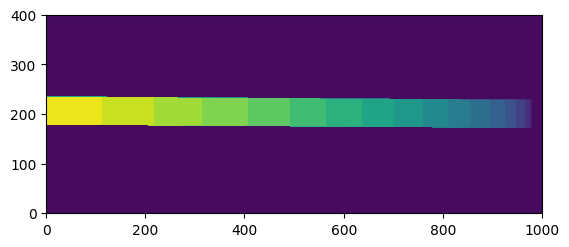

In [157]:
fig, ax = plt.subplots()
ax.contourf(velocity, levels=20)
ax.set_aspect("equal")